In [8]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import warnings 
warnings.filterwarnings('ignore')

import datetime as dt

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 25
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [9, 6]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 3)) #n: number of the lines you want to plot 
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['datadate','industry_id','forward_excess_ret','binary_class','multi_class','tic',
                     'abnormal_volume', 'MA3', 'MA6', 'MA12', 'EMA3', 'EMA6', 'EMA12',
                    'NI_growth', 'Size', 'PriceCap', 'ROE', 'ROA', 'ROI', 'NetPM',
                   'epspi12', 'earnings', 'earningsVol', 'Asset Turnover', 'PE', 'PB',
                   'PS', 'dividend_yield', 'ev_ebitda', 'NCFP']]
industry_dummy = pd.get_dummies(features['industry_id'])
features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['forward_excess_ret','binary_class','multi_class'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','binary_class','multi_class','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

In [3]:
for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t



for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [4]:
features_after['up_down'] = features_after['forward_excess_ret'].apply(lambda x: int(x>0))

## Backtest
### Rolling
Use the past 12 months(if there are not 12 months in the past, use all the historical data) as the test set to train our model. Then apply the trained model on every month on a rolling basis.

Every month, long the top 10% (aboout 50 stocks) with the higheset predicted excess returns and short the bottom 10% that are predicted to gain the lowest returns.


Calculate the cumulative returns over time: 

$r_t = \frac{1}{n}\sum_i^n r_{long} -  \frac{1}{n}\sum_i^n r_{short}$

$Cumulative\_Return_T = \sum_i^T r_t$

In [49]:
def long_quantile(data):
    return(data[data['pred']>=data['pred'].quantile(0.9)])
    
def short_quantile(data):
    return(data[data['pred']<=data['pred'].quantile(0.1)])

def group_precision(df,keyword):
    temp = df.groupby(by=[keyword,'pred_class']).size().reset_index()
    temp.columns=['True','Predict','Size']
    temp = temp.pivot(index='True',columns='Predict',values='Size')
    return(temp)

In [71]:
def backtest_rolling(df,model,keyword):    
    # df should be a cleaned dataframe with all factors and datadate
    # model is the regression model initialized(no warm start)
    # keyword can be forward_excess_ret, binary_class, multi_class and up_down
    feature_names=['MA12','Asset Turnover','Size','epspi12','ROE','PS','Size','ev_ebitda','NCFP']
    
    p = pd.DataFrame()
    datelist = list(df['datadate'].drop_duplicates())
    precision = pd.DataFrame()
    for m in range(2,len(datelist)):
        date_range = datelist[max(0,m-12):m-1]
        train = df[df.datadate.isin(date_range)]
        X_train = train[feature_names]
        y_train = train[keyword]
        test = df[df.datadate==datelist[m]]
        X_test = test[feature_names]
        y_test = test[keyword]
        
        model = model.fit(X_train,y_train)

        if keyword == 'forward_excess_ret' or keyword == 'multi_class':
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            train['pred'] = y_train_pred
            test['pred'] = y_test_pred
        else:
            y_train_pred = model.predict_proba(X_train)
            y_test_pred = model.predict_proba(X_test)
            train['pred'] = y_train_pred[:,1]
            test['pred'] = y_test_pred[:,1]
                                         
        
        
        
        
        if keyword == 'forward_excess_ret':
            1
        else:
            test['pred_class'] = test['pred'].apply(lambda x:round(x))            
            test['precision'] = (test['pred_class']-test[keyword]).apply(lambda x: int(x==0))
            precision = precision.append(test[['pred_class',keyword]])
        
        if keyword == 'multi_class':
            long = test[test.pred==9]
            short = test[test.pred==0]
        else:
            long = test.groupby(by=['datadate']).apply(long_quantile).reset_index(drop=True)
            short = test.groupby(by=['datadate']).apply(short_quantile).reset_index(drop=True)

        portfolio = long.groupby(by=['datadate'])['forward_excess_ret'].mean().reset_index()
        portfolio.columns = ['datadate','long_ret']
        temp = short.groupby(by=['datadate'])['forward_excess_ret'].mean().reset_index()
        temp.columns=['datadate','short_ret']
        portfolio = pd.merge(portfolio,temp)
        portfolio['ret'] = (portfolio['long_ret'] - portfolio['short_ret'])
        try:
            portfolio['precision'] = test['precision'].mean()
        except:
            1
        portfolio.index = portfolio['datadate'].apply(lambda x: dt.datetime.strptime(str(x),'%Y%m%d'))        
        
        p = p.append(portfolio)
        
    p['cum_ret'] = p['ret'].cumsum()

    plt.plot(p['cum_ret'],label='cumulative return')
    plt.legend()
    plt.show()
    
    
    if keyword == 'forward_excess_ret':
        1
    else:    
        plt.plot(p['precision'],label='precision',color=colors[0])
        plt.legend()
        plt.show()
        
        print('Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)')
        precision = group_precision(precision,keyword)
        sns.heatmap(precision,annot=True, fmt="d",cmap="YlGnBu")
        plt.show()
        
    
    annual_ret = p['ret'].mean()*12
    annual_std = p['ret'].std()*np.sqrt(12)
    
    ret = list(p['cum_ret']+1)
    max_drawdown = 2
    for i in range(2,len(ret)):
        temp = min(ret[:i-1])
        max_drawdown = min(temp/ret[i],max_drawdown)
    max_drawdown = 1-max_drawdown
        

    print('Annual_ret:',annual_ret,'\n')
    print('Sharpe Ratio:',annual_ret/annual_std,'\n')
    print('Max_drawdown:',max_drawdown)
    
    return(p)

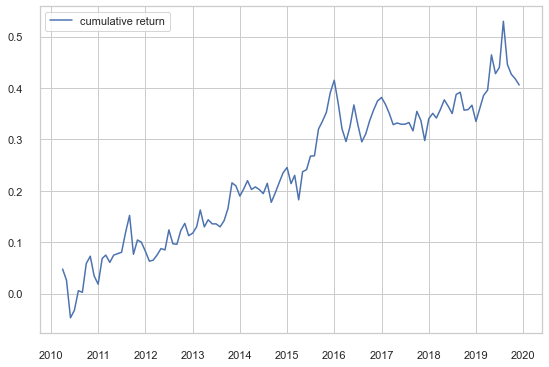

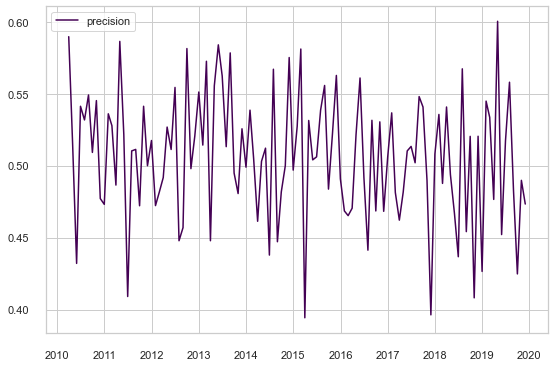

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


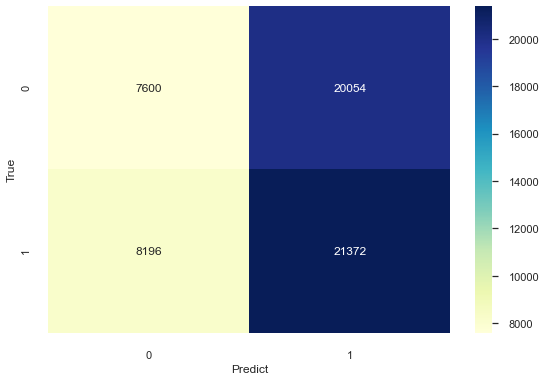

Annual_ret: 0.041640831324275644 

Sharpe Ratio: 0.4109713684454268 

Max_drawdown: 0.37701795737414867


In [68]:
model = RandomForestClassifier(max_depth=4, n_estimators=100, max_features='auto')
p = backtest_rolling(features_after,model,keyword='up_down')

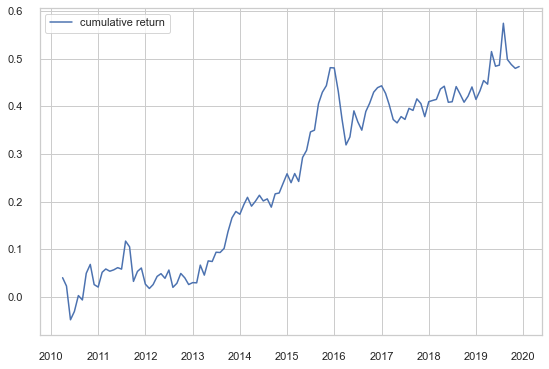

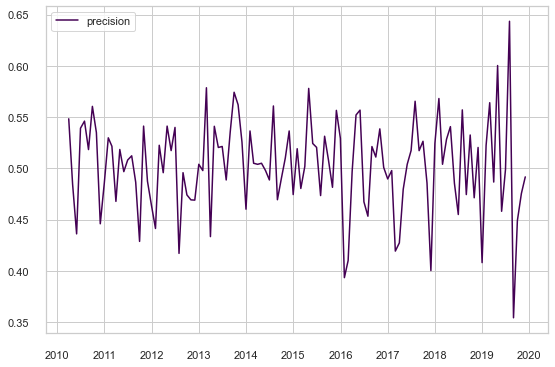

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


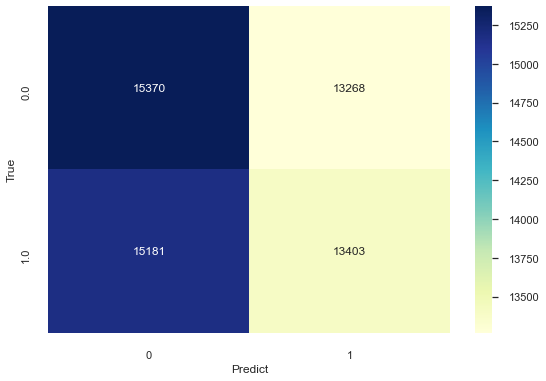

Annual_ret: 0.04959985728579773 

Sharpe Ratio: 0.5120052476986182 

Max_drawdown: 0.3955029411904859


In [69]:
model = RandomForestClassifier(max_depth=4, n_estimators=100, max_features='auto')
p = backtest_rolling(features_after,model,keyword='binary_class')

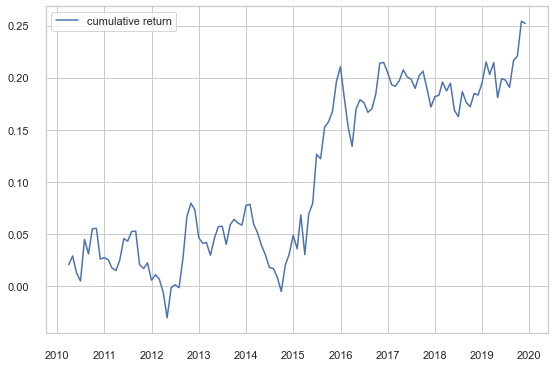

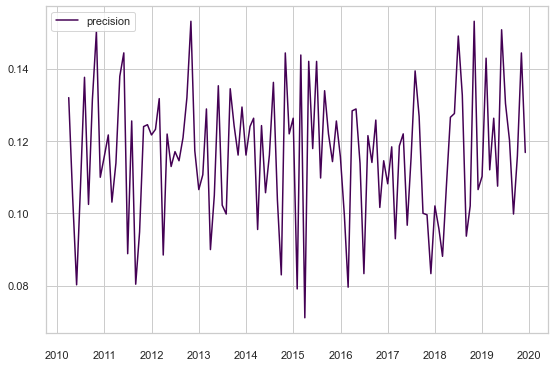

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


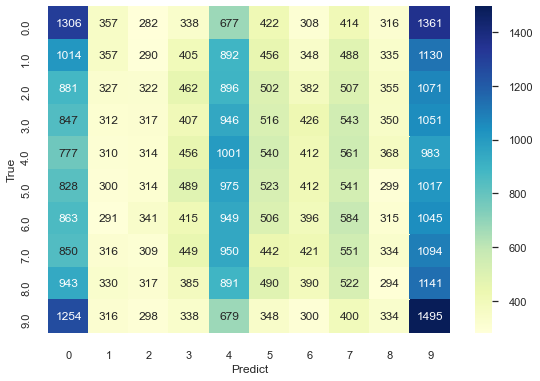

Annual_ret: 0.02584759816520764 

Sharpe Ratio: 0.4305475615342865 

Max_drawdown: 0.22682038638047997


In [72]:
model = RandomForestClassifier(max_depth=4, n_estimators=100, max_features='auto')
p = backtest_rolling(features_after,model,keyword='multi_class')

In [ ]:
model = RandomForestRegressor(max_depth=4, n_estimators=100, max_features='auto')
p = backtest_rolling(features_after,model,keyword='forward_excess_ret')

### Temp

In [65]:
feature_names=['MA12','Asset Turnover','Size','epspi12','ROE','PS','Size','ev_ebitda','NCFP']
datelist = list(features_after['datadate'].drop_duplicates())
m = 78
date_range = datelist[m-12:m-1]
train = features_after[features_after.datadate.isin(date_range)]
X_train = train[feature_names]
y_train = train['up_down']
test = features_after[features_after.datadate==datelist[m]]
X_test = test[feature_names]
y_test = test['up_down']
#reg = RandomForestClassifier(max_depth=4, n_estimators=100, max_features='auto')
reg.fit(X_train,y_train)
logistic_predict=reg.predict_proba(X_test)